# CSP Solver am Beispiel Kakuro

```
 *   | s_0 | s_1 |
------------------
 s_2 |  a  |  b  |
------------------
 s_3 |  c  |  d  | 
------------------
```

In [1]:
from qiskit.algorithms import Grover
import numpy as np
from mqt import ddsim
from qiskit import *

In [2]:
s0_input = 1
s1_input = 3
s2_input = 3
s3_input = 1

In [3]:

s0_low = QuantumRegister(1, 's0_low')
s0_high = QuantumRegister(1, 's0_high')
s0 = (s0_low, s0_high)
s1_low = QuantumRegister(1, 's1_low')
s1_high = QuantumRegister(1, 's1_high')
s1 = (s1_low, s1_high)
s2_low = QuantumRegister(1, 's2_low')
s2_high = QuantumRegister(1, 's2_high')
s2 = (s2_low, s2_high)
s3_low = QuantumRegister(1, 's3_low')
s3_high = QuantumRegister(1, 's3_high')
s3 = (s3_low, s3_high)

a_low = QuantumRegister(1, 'a_low')
a_high = QuantumRegister(1, 'a_high')
a = (a_low, a_high)
b_low = QuantumRegister(1, 'b_low')
b_high = QuantumRegister(1, 'b_high')
b = (b_low, b_high)
c_low = QuantumRegister(1, 'c_low')
c_high = QuantumRegister(1, 'c_high')
c = (c_low, c_high)
d_low = QuantumRegister(1, 'd_low')
d_high = QuantumRegister(1, 'd_high')
d = (d_low, d_high)

anc = QuantumRegister(28, 'anc')
anc_mct = QuantumRegister(10, 'mct_ancilla')
flag = QuantumRegister(1, 'flag')
qc = QuantumCircuit(a_low, a_high, b_low, b_high, c_low, c_high, d_low, d_high, s0_low, s0_high, s1_low, s1_high, s2_low, s2_high, s3_low, s3_high, anc, anc_mct, flag)
ninputs = 8
nqubits = 17
nancilla = anc.size + anc_mct.size

In [4]:
nancilla + nqubits

55

## Encoding of Input Values

In [5]:

if s0_input == 1:
    qc.x(s0_low)
elif s0_input == 2:
    qc.x(s0_high)
elif s0_input == 3:
    qc.x(s0_low)
    qc.x(s0_high)
    
if s1_input == 1:
    qc.x(s1_low)
elif s1_input == 2:
    qc.x(s1_high)
elif s1_input == 3:
    qc.x(s1_low)
    qc.x(s1_high)
    
if s2_input == 1:
    qc.x(s2_low)
elif s2_input == 2:
    qc.x(s2_high)
elif s2_input == 3:
    qc.x(s2_low)
    qc.x(s2_high)
    
if s3_input == 1:
    qc.x(s3_low)
elif s3_input == 2:
    qc.x(s3_high)
elif s3_input == 3:
    qc.x(s3_low)
    qc.x(s3_high)

## Function Definition for Inequality, equality and addition

In [6]:
def check_equality(qc, x, y, res_anc):
    x_low, x_high = x
    y_low, y_high = y
    
    qc.cx(x_high, y_high)
    qc.x(y_high)
    qc.cx(x_low, y_low)
    qc.x(y_low)
    
    qc.rccx(y_low, y_high, res_anc)
    
    #Uncompute
    qc.x(y_low)
    qc.cx(x_low, y_low)
    qc.x(y_high)
    qc.cx(x_high, y_high)

def check_inequality(qc, x, y, res_anc):
    check_equality(qc, x, y, res_anc)
    qc.x(res_anc)


def check_input_not_3(qc, low, high, res_anc):
    qc.rccx(low, high, res_anc)
    qc.x(res_anc)

def add_two_numbers(qc, x, y, ancs, res_anc_low, res_anc_high):
    x_low, x_high = x
    y_low, y_high = y
    
    
    qc.rccx(x_low, y_low, ancs[0])
    qc.cx(x_low, y_low)
    qc.cx(y_low, res_anc_low)
    qc.cx(x_high, y_high)
    qc.cx(y_high, ancs[1])
    qc.x(ancs[0])
    qc.x(ancs[1])
    
    qc.rccx(ancs[0], ancs[1], res_anc_high)
    qc.x(res_anc_high)

    #Uncompute
    qc.x(ancs[0])
    qc.x(ancs[1])
    qc.cx(y_high, ancs[1])
    qc.cx(x_high, y_high)
    qc.cx(x_low, y_low)
    qc.rccx(x_low, y_low, ancs[0])
    
    return (res_anc_low, res_anc_high)

# Check Functions and their result

## Inequality

In [7]:
for i in range(2**4):

    t1_low = QuantumRegister(1, 't1_low')
    t1_high = QuantumRegister(1, 't1_high')
    t1 = (t1_low, t1_high)
    t2_low = QuantumRegister(1, 't2_low')
    t2_high = QuantumRegister(1, 't2_high')
    t2 = (t2_low, t2_high)
    t_anc = QuantumRegister(1, 't_anc')
    t_anc_classical = ClassicalRegister(1, 't_anc_classical')
       
    qc_test_inequality = QuantumCircuit(t1_low, t1_high, t2_low, t2_high, t_anc, t_anc_classical)
    for j in range(4):
        if (i>>j) % 2 == 1:
            qc_test_inequality.x(j)

    check_inequality(qc_test_inequality, t1, t2, t_anc)
    qc_test_inequality.measure(t_anc, t_anc_classical)

    backend = ddsim.DDSIMProvider().get_backend('qasm_simulator')
    job = execute(qc_test_inequality, backend, shots=10)
    counts = job.result().get_counts(qc_test_inequality)
    print("{0:b}".format(i), counts)

0 {'0': 10}
1 {'1': 10}
10 {'1': 10}
11 {'1': 10}
100 {'1': 10}
101 {'0': 10}
110 {'1': 10}
111 {'1': 10}
1000 {'1': 10}
1001 {'1': 10}
1010 {'0': 10}
1011 {'1': 10}
1100 {'1': 10}
1101 {'1': 10}
1110 {'1': 10}
1111 {'0': 10}


/Users/nils/miniforge3/envs/tf3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/nils/miniforge3/envs/tf3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


## Equality

In [8]:
for i in range(2**4):

    t1_low = QuantumRegister(1, 't1_low')
    t1_high = QuantumRegister(1, 't1_high')
    t1 = (t1_low, t1_high)
    t2_low = QuantumRegister(1, 't2_low')
    t2_high = QuantumRegister(1, 't2_high')
    t2 = (t2_low, t2_high)
    t_anc = QuantumRegister(1, 't_anc')
    t_anc_classical = ClassicalRegister(1, 't_anc_classical')
       
    qc_test_equality = QuantumCircuit(t1_low, t1_high, t2_low, t2_high, t_anc, t_anc_classical)
    for j in range(4):
        if (i>>j) % 2 == 1:
            qc_test_equality.x(j)




    check_equality(qc_test_equality, t1, t2, t_anc)
    qc_test_equality.measure(t_anc, t_anc_classical)

    backend = ddsim.DDSIMProvider().get_backend('qasm_simulator')
    job = execute(qc_test_equality, backend, shots=10)
    counts = job.result().get_counts(qc_test_equality)
    print("{0:b}".format(i), counts)

0 {'1': 10}
1 {'0': 10}
10 {'0': 10}
11 {'0': 10}
100 {'0': 10}
101 {'1': 10}
110 {'0': 10}
111 {'0': 10}
1000 {'0': 10}
1001 {'0': 10}
1010 {'1': 10}
1011 {'0': 10}
1100 {'0': 10}
1101 {'0': 10}
1110 {'0': 10}
1111 {'1': 10}


## Addition

In [9]:
for i in range(2**4):
    t1_low = QuantumRegister(1, 't1_low')
    t1_high = QuantumRegister(1, 't1_high')
    t1 = (t1_low, t1_high)
    t2_low = QuantumRegister(1, 't2_low')
    t2_high = QuantumRegister(1, 't2_high')
    t2 = (t2_low, t2_high)
    t_ancs = QuantumRegister(2, 't_ancs')
    t_anc_low = QuantumRegister(1, 't_anc_low')
    t_anc_low_classical = ClassicalRegister(1, 't_anc_low_classical')
    t_anc_high = QuantumRegister(1, 't_anc_high')
    t_anc_high_classical = ClassicalRegister(1, 't_anc_high_classical')

    qc_test_adittion = QuantumCircuit(t1_low, t1_high, t2_low, t2_high, t_ancs, t_anc_low, t_anc_high, t_anc_low_classical, t_anc_high_classical)

    for j in range(4):
        if (i>>j) % 2 == 1:
            qc_test_adittion.x(j)

    tmp_1 = add_two_numbers(qc_test_adittion, t1, t2, t_ancs, t_anc_low, t_anc_high)

    qc_test_adittion.measure(t_anc_low, t_anc_low_classical)
    qc_test_adittion.measure(t_anc_high, t_anc_high_classical)

    backend = ddsim.DDSIMProvider().get_backend('qasm_simulator')
    job = execute(qc_test_adittion, backend, shots=10)
    counts = job.result().get_counts(qc_test_adittion)
    print("{0:b}".format(i), counts)

0 {'0 0': 10}
1 {'0 1': 10}
10 {'1 0': 10}
11 {'1 1': 10}
100 {'0 1': 10}
101 {'1 0': 10}
110 {'1 1': 10}
111 {'1 0': 10}
1000 {'1 0': 10}
1001 {'1 1': 10}
1010 {'0 0': 10}
1011 {'0 1': 10}
1100 {'1 1': 10}
1101 {'1 0': 10}
1110 {'0 1': 10}
1111 {'1 0': 10}


# Encoding of Constraints

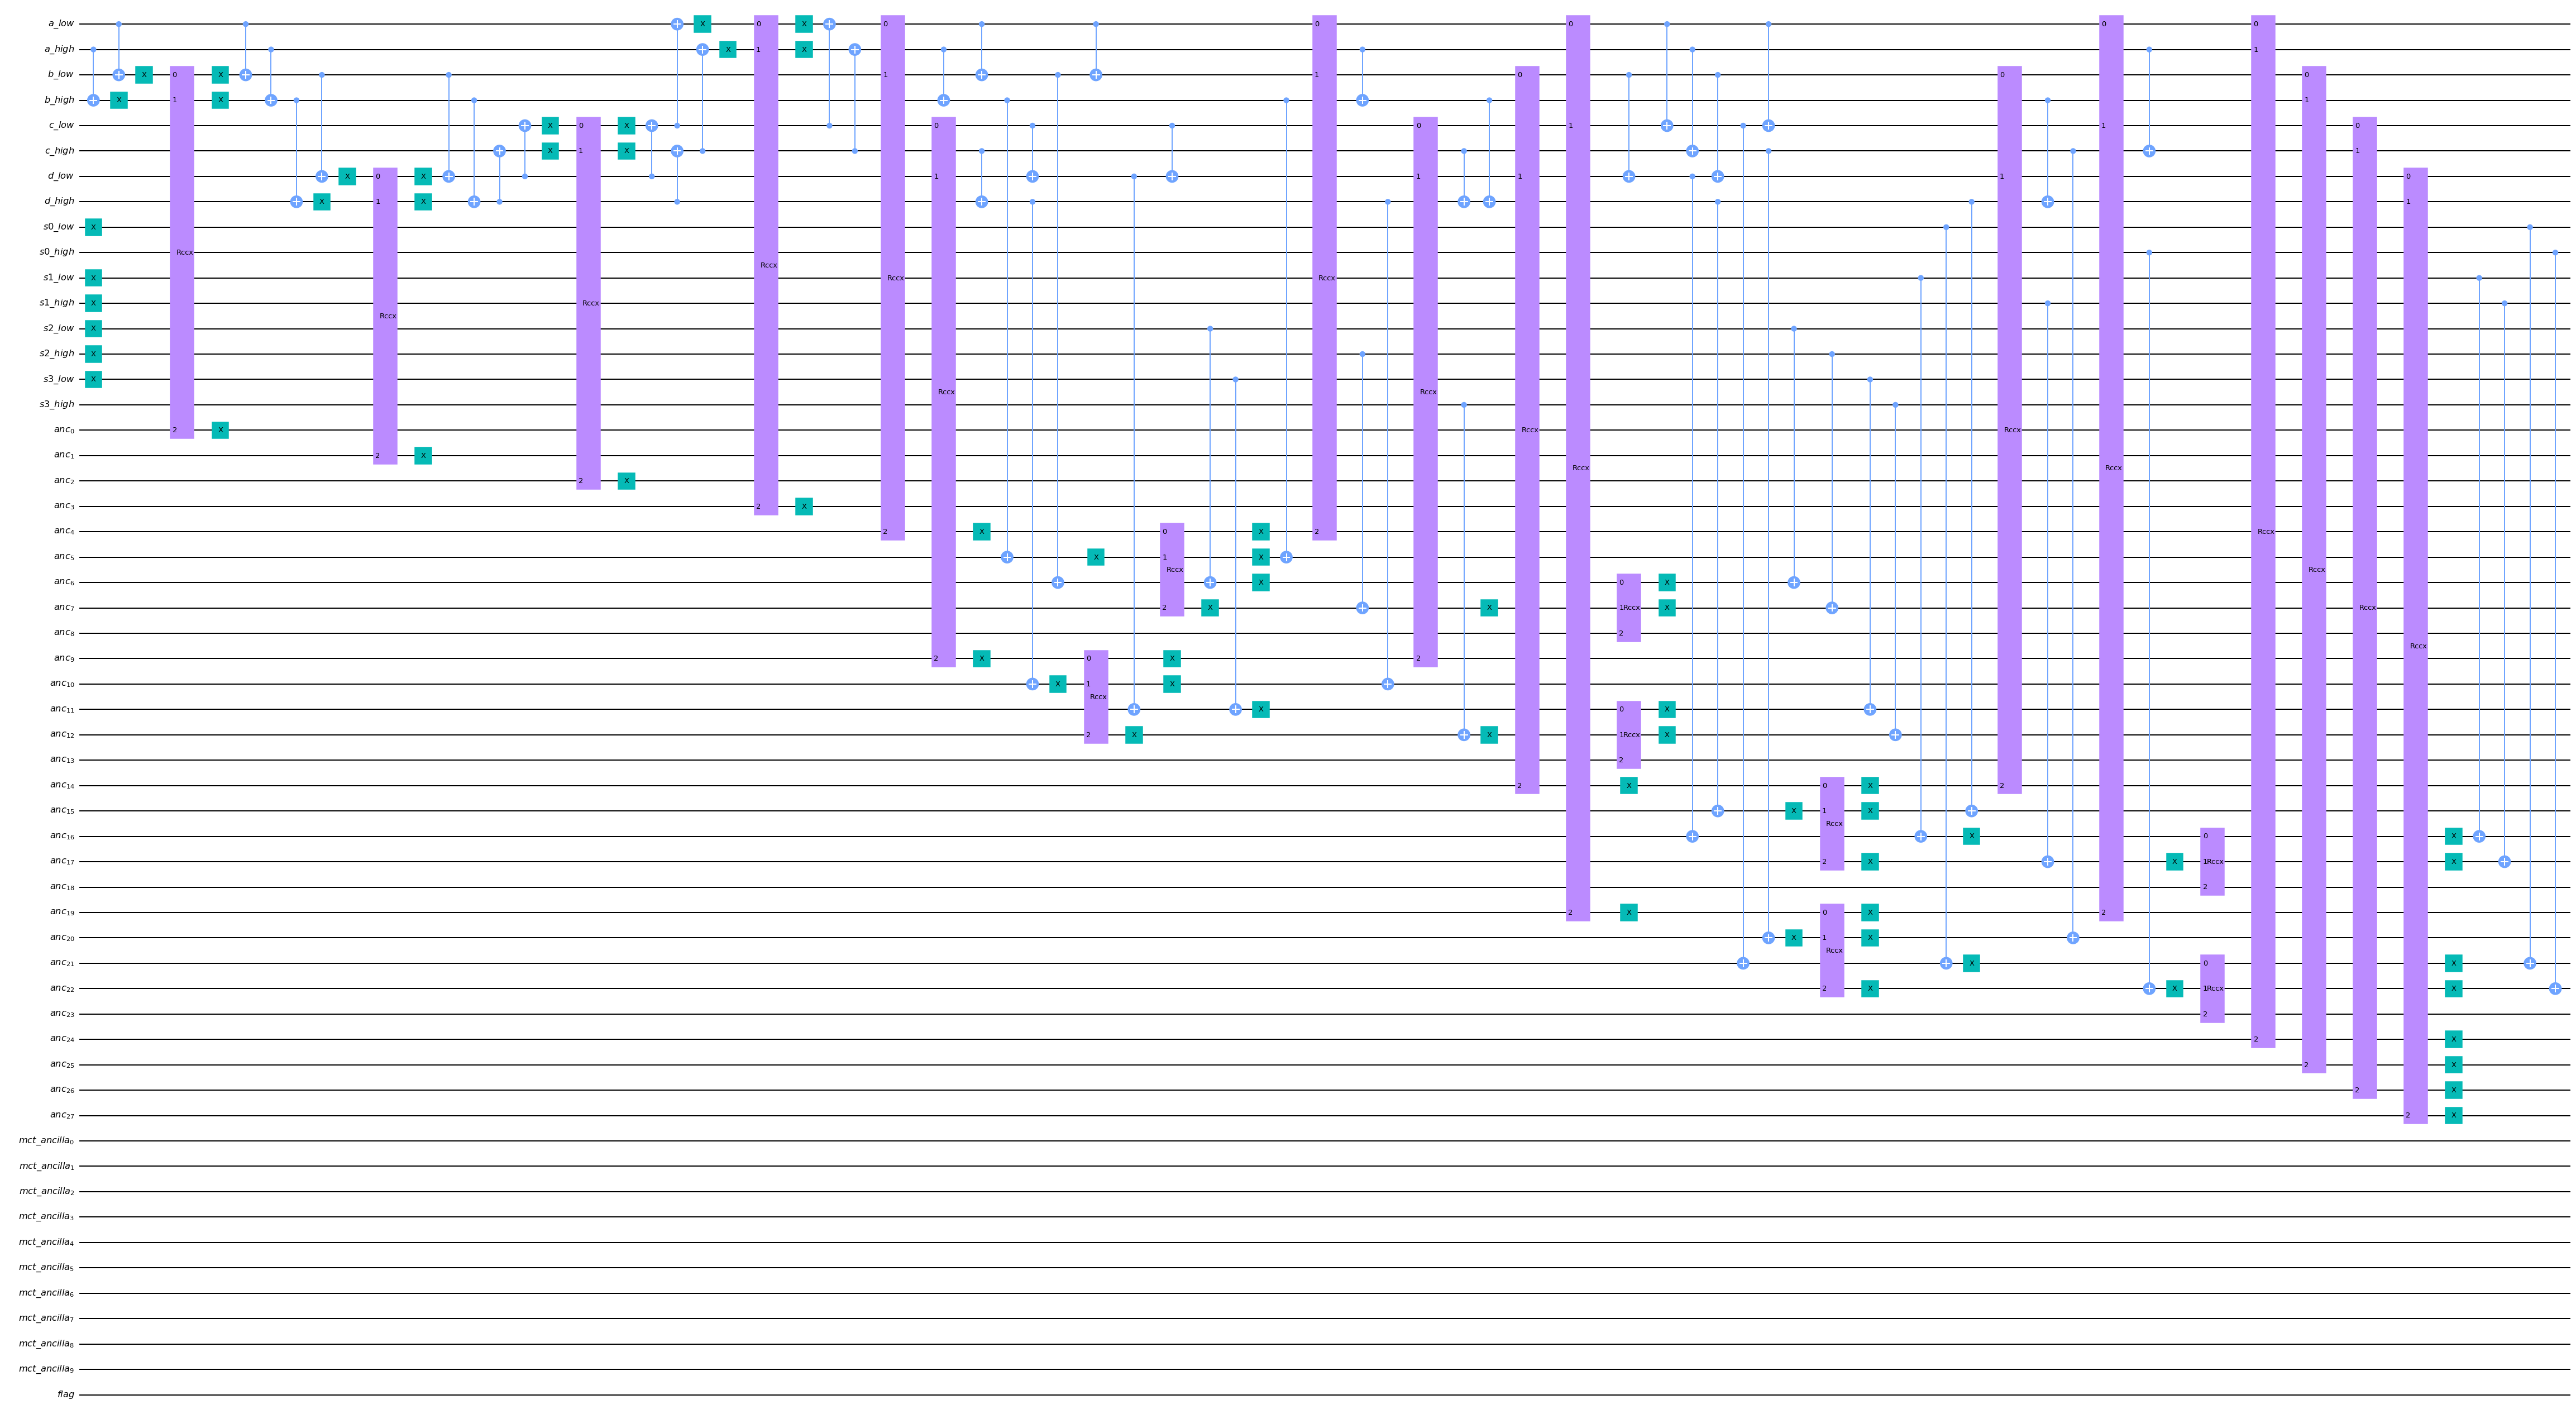

In [10]:
mct_list=[]

# Inequalities
check_inequality(qc, a, b, anc[0])
mct_list.append(anc[0])
check_inequality(qc, b, d, anc[1])
mct_list.append(anc[1])
check_inequality(qc, d, c, anc[2])
mct_list.append(anc[2])
check_inequality(qc, c, a, anc[3])
mct_list.append(anc[3])


# Equalities
tmp_1 = add_two_numbers(qc, a, b, anc[4:6], anc[6], anc[7])
check_equality(qc, s2, tmp_1, anc[8])
mct_list.append(anc[8])

tmp_2 = add_two_numbers(qc, c, d, anc[9:11], anc[11], anc[12])
check_equality(qc, s3, tmp_2, anc[13])
mct_list.append(anc[13])

tmp_3 = add_two_numbers(qc, b, d, anc[14:16], anc[16], anc[17])
check_equality(qc, s1, tmp_3, anc[18])
mct_list.append(anc[18])

tmp_4 = add_two_numbers(qc, a, c, anc[19:21], anc[21], anc[22])
check_equality(qc, s0, tmp_4, anc[23])
mct_list.append(anc[23])

# Restrict a,b,c,d to be not 3
check_input_not_3(qc, a_low, a_high, anc[24])
mct_list.append(anc[24])
check_input_not_3(qc, b_low, b_high, anc[25])
mct_list.append(anc[25])
check_input_not_3(qc, c_low, c_high, anc[26])
mct_list.append(anc[26])
check_input_not_3(qc, d_low, d_high, anc[27])
mct_list.append(anc[27])

qc.draw(output='mpl', fold=-1)

# Create Oracle

Complete Oracle (CX):  198
Complete Oracle (U):  230


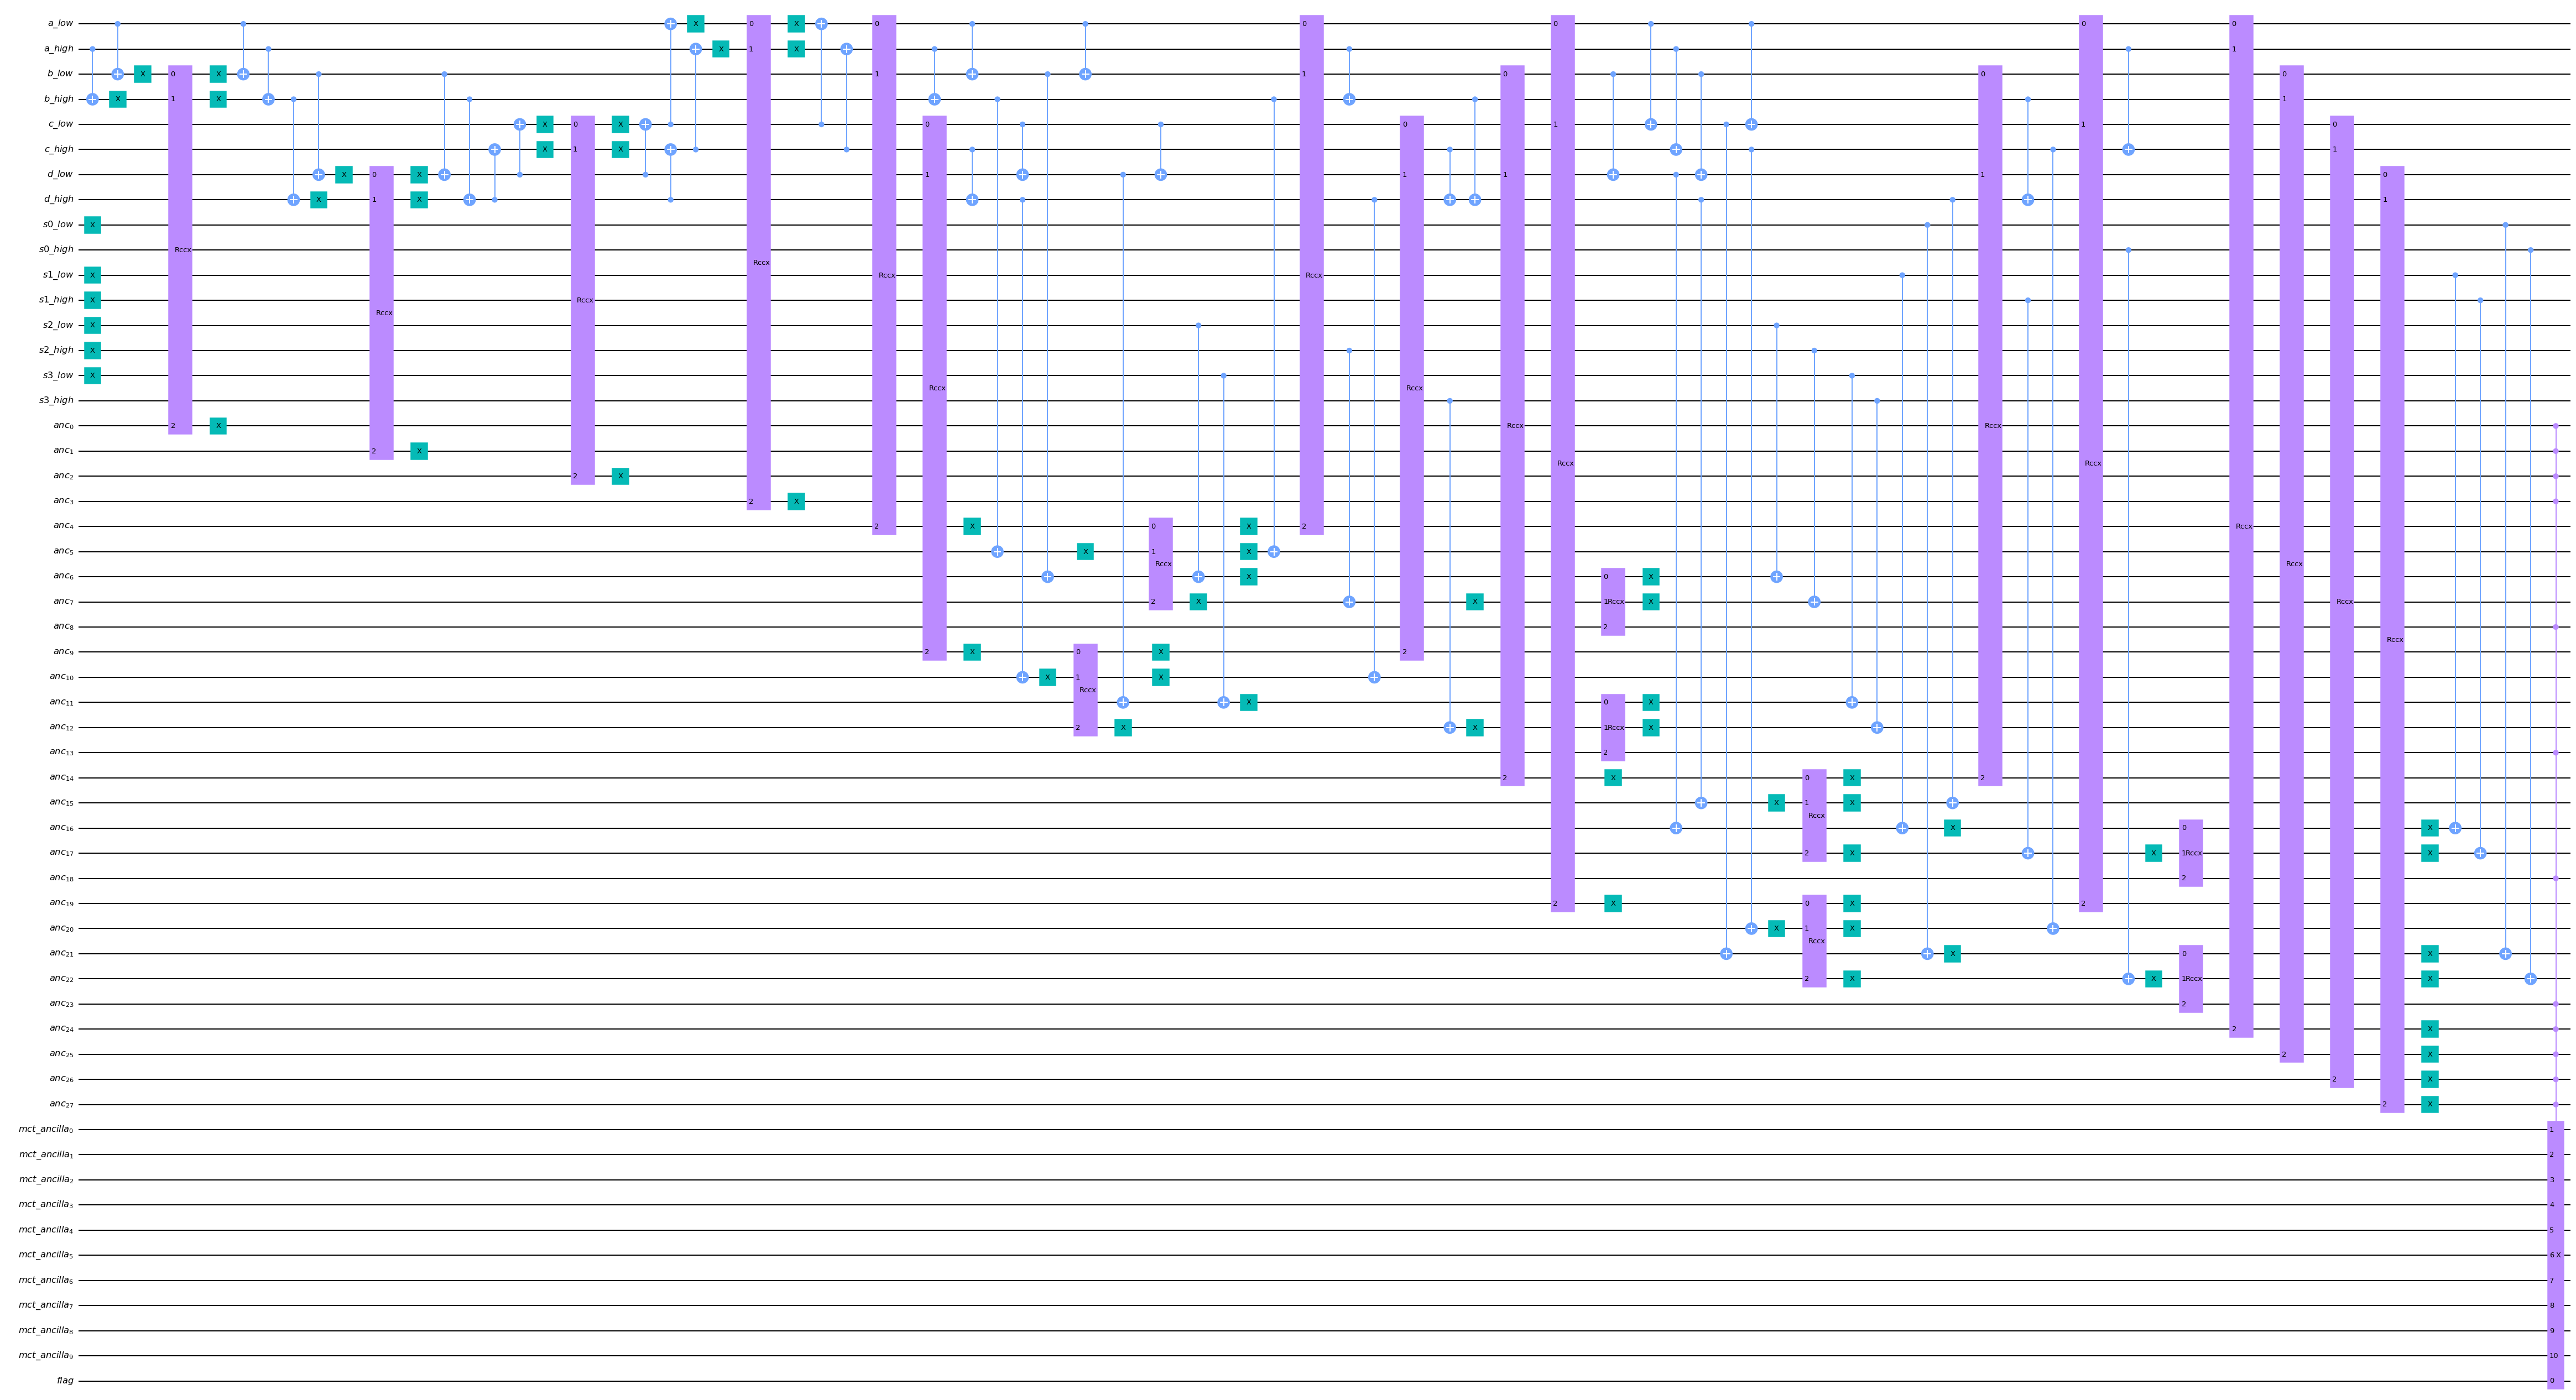

In [11]:
compute = qc.to_instruction()

# mark solution
qc.mct(mct_list, flag, ancilla_qubits=anc_mct, mode='v-chain')

# uncompute
#uncompute = compute.inverse()
#uncompute.name = 'uncompute'
#qc.append(uncompute, range(qc.num_qubits))


print("Complete Oracle (CX): ", transpile(qc, basis_gates=['u', 'cx']).count_ops()['cx'])
print("Complete Oracle (U): ", transpile(qc, basis_gates=['u', 'cx']).count_ops()['u'])
oracle = qc.to_instruction(label='oracle')
qc.draw(output='mpl', fold=-1)

# Testing the Oracle

In [ ]:
from qiskit.algorithms import Grover
import numpy as np
from mqt import ddsim
backend = ddsim.DDSIMProvider().get_backend('qasm_simulator')
print(nqubits+nancilla, oracle.num_qubits)
for i in range(2**8):
    new = QuantumCircuit(nqubits+nancilla, 1)
    for j in range(8):
        if (i>>j) % 2 == 1:
            new.x(j)
    new.append(oracle, range(nqubits+nancilla))
    new.measure(54, 0)

    job = execute(new, backend, shots=10)
    counts = job.result().get_counts(new)
    #print("{0:b}".format(i), counts)
    if counts.get("1"):
        print("{0:b}".format(i), counts)


55 55


/Users/nils/miniforge3/envs/tf3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/nils/miniforge3/envs/tf3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


1001001 {'1': 10}


# Embedding in Grover Algorithm

In [ ]:
from qiskit.algorithms import Grover
import numpy as np
from mqt import ddsim

qc = QuantumCircuit(nqubits+nancilla, ninputs)
qc.h(range(ninputs))
qc.x(nqubits+nancilla-1)
qc.h(nqubits+nancilla-1)

num_iterations = Grover.optimal_num_iterations(1, ninputs)

#print(num_iterations)
for _ in range(num_iterations):
    qc.append(oracle, range(nqubits+nancilla))
    qc.h(range(ninputs))
    qc.x(range(ninputs))
    qc.mcp(np.pi, list(range(ninputs-1)), ninputs-1)
    qc.x(range(ninputs))
    qc.h(range(ninputs))
qc.measure(range(ninputs), range(ninputs))
qc.qasm(filename='grover_algorithm.qasm')

backend = ddsim.DDSIMProvider().get_backend('qasm_simulator')
job = execute(qc, backend, shots=1)
counts = job.result().get_counts(qc)
print(counts)